# Logistic Regression Results Comparison
This time we used the `liblinear` solver from scikit-learn

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
smith_results = pd.read_csv("./results/representation_learning_transcriptomics_results.csv")
tcga_classification_tasks = pd.read_csv("./data_utilities/tcga_classification_tasks.csv")

In [3]:
binary = smith_results['label_type'] == 'binary'
l2 = smith_results['supervised_model'] == 'logistic regression'
no_embedding = smith_results['unsupervised_model'] == 'no embedding'
gene_set = smith_results['gene_set'] == 'all'
norm = smith_results['normalization'] == 'clr'
tcga = ["GSE" not in e for e in smith_results['task']]

In [4]:
tcga_results_smith = smith_results[binary & no_embedding & gene_set & norm & tcga & l2].copy()

In [5]:
tcga_results_smith.shape

(18, 13)

In [6]:
tcga_results_smith.sort_values(by='task', inplace=True)
tcga_results_smith.head(5)

,unsupervised_model,supervised_model,gene_set,normalization,task,group,label_type,num_genes,num_features,num_samples,num_classes,score,score_units
29,no embedding,logistic regression,all,clr,BRCA stage,test,binary,57992,57992,1134,2,0.625216,AUC
34,no embedding,logistic regression,all,clr,CESC grade,train,binary,57992,57992,306,2,0.707146,AUC
36,no embedding,logistic regression,all,clr,COAD stage,train,binary,57992,57992,505,2,0.686547,AUC
38,no embedding,logistic regression,all,clr,HNSC grade,test,binary,57992,57992,504,2,0.698141,AUC
26,no embedding,logistic regression,all,clr,KIRC grade,train,binary,57992,57992,544,2,0.593343,AUC


### Now load the results files

In [7]:
filenames = os.listdir("./results/l2-liblinear/")
results = [pd.read_csv(f"./results/l2-liblinear/{f}") for f in filenames]

In [8]:
mean_performance = [r['auc'].mean() for r in results]
tasks = [" ".join(f.split('_')[3:5]) for f in filenames]

In [9]:
aggregated_results = pd.DataFrame()
aggregated_results['results'] = mean_performance
aggregated_results['task'] = tasks

In [10]:
aggregated_results.sort_values(by='task', inplace=True)
aggregated_results.head(5)

,results,task
13,0.640705,BRCA stage
17,0.717279,CESC grade
15,0.695441,COAD stage
7,0.737131,HNSC grade
12,0.639372,KIRC grade


In [11]:
# check they are aligned correctly
assert(all( [a == b for a,b in zip(aggregated_results['task'], tcga_results_smith['task'])] ))

In [12]:
sns_data = pd.DataFrame()
sns_data['Task'] = aggregated_results['task'].values
sns_data['OurResults'] = aggregated_results['results'].values
sns_data['SmithResults'] = tcga_results_smith['score'].values

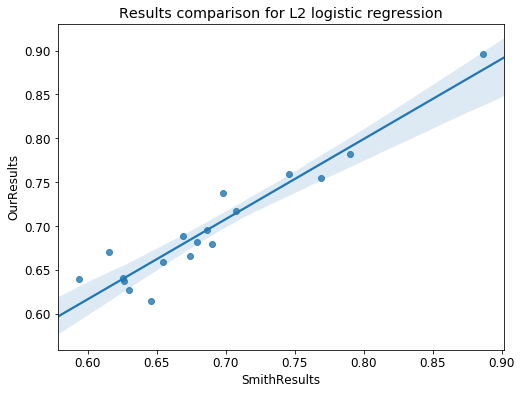

In [13]:
plt.rcParams['figure.figsize'] = 8.0, 6.0
plt.rcParams['font.size'] = 12.0
sns.regplot(data=sns_data, x="SmithResults", y="OurResults")
plt.title('Results comparison for L2 logistic regression');

In [14]:
# test for bias
from scipy.stats import ttest_rel, describe

In [15]:
ttest_rel(a=sns_data['OurResults'], b=sns_data['SmithResults'])

Ttest_relResult(statistic=1.7717046983446136, pvalue=0.09436643625064335)

In [16]:
# no bias present

In [19]:
sns_data['Differences'] = sns_data['OurResults'] - sns_data['SmithResults']
describe(sns_data['Differences'])
sns_data.sort_values(by='Differences', inplace=True)
n_obs = len(sns_data)

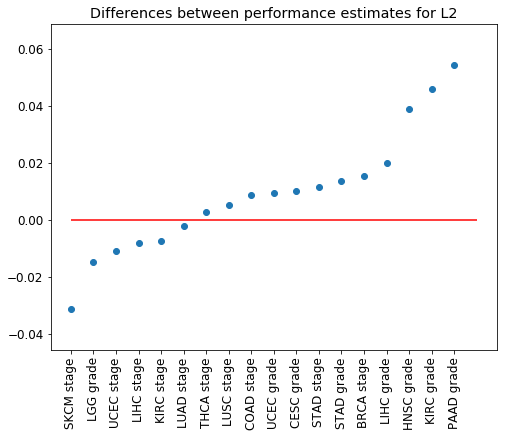

In [20]:
plt.scatter(x=sns_data['Task'], y=sns_data['Differences'])
plt.hlines(y=0, xmin=0, xmax=n_obs, colors='r')
plt.xticks(rotation=90);
plt.title("Differences between performance estimates for L2");